In [ ]:
# -*- coding: utf-8 -*-
# @ Desc: Example to process the osm_cellids data

# set workspace to the root of the project
import os
workspace_path = '../..'
os.chdir(workspace_path)
print("Current workspace:", os.getcwd())

In [ ]:
import numpy as np
from neurbench.index.util import load_key_set, KeyType, save_file
from neurbench.index.bench import KeySetBinEncoder, sample_bulkloading_keyset
from neurbench.drift import find_q
import matplotlib.pyplot as plt

In [3]:
import matplotlib.font_manager as font_manager

font_path = "/users/lingze/times.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
print(prop.get_name())

Times New Roman


In [4]:
# # load osm_cellids data and downsample it to 200M keys
# keyset_file_path = "/users/lingze/TLI/data/osm_cellids_800M_uint64"
# output_file_path = "/users/lingze/TLI/data/osm_cellids_200M_uint64"
# d = np.fromfile(keyset_file_path, dtype=np.uint64)[1:]

# nd = d[::4]
# with open(output_file_path, "wb") as f:
#     f.write(np.array([nd.size], dtype=np.uint64))
#     nd.tofile(f)


In [5]:
# load osm_cellids_200M_uint64 data
keyset_file_path = "/users/lingze/TLI/data/osm_cellids_200M_uint64"
data = load_key_set(keyset_file_path)


In [6]:
# get data type and check unique
data_type = KeyType.resolve_type_from_filename(keyset_file_path)
print(data_type)
# flag = len(np.unique(data)) == len(data)
# print("Data is unique:", flag)

KeyType.UINT64


In [7]:
"""plot the data Cumulative Distribution Function (CDF)
"""
# max_value = np.max(data)
# min_value = np.min(data)
# print("Max value:", max_value)
# print("Min value:", min_value)
# KeySetBinEncoder.plot_cdf(
#     data,
#     min_value=min_value,
#     max_value=max_value,
# )

'plot the data Cumulative Distribution Function (CDF)\n'

In [8]:
"""abnormal key filter
# before we get the data distribution of key set
# we need to filter out the abnormal keys
"""
keys, removed_key = KeySetBinEncoder.filter_abnormal_values(data, "CONFIDENCE", verbose = True)
print("Remove rate:", len(removed_key) / len(data))

Filtered 3004802 values, [196995198 / 200000000]
Remove rate: 0.01502401


Total number of bins: 243


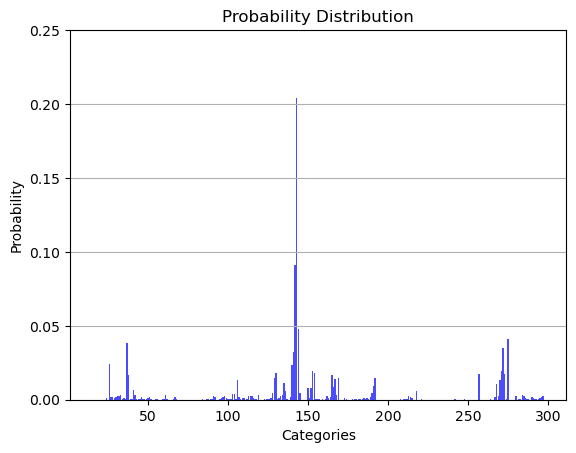

In [9]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, prob, bin_idx_to_keys = KeySetBinEncoder.bin_keyset_to_distribution(
    keys,
    bin_width_offset=bin_width_offset,
    verbose=True
)
KeySetBinEncoder.plot_probability_distribution(prob, bin_idxs.tolist())

In [10]:

min_bin_num = int(np.min(bin_idxs))
max_bin_num = int(np.max(bin_idxs))
prob_dict = {}

for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = prob[i]

x = [ i for i in range(min_bin_num, max_bin_num+1)]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

In [ ]:

# labels = x
# max_value = max(y)
# rounded_max_value = np.ceil(max_value * 50) / 50
# # rounded 0.05
# y_ = [ i * 100 for i in y]
# plt.rcParams['xtick.labelsize']=15
# plt.rcParams['ytick.labelsize']=15
# fig, ax = plt.subplots(figsize=(4, 2.5))
# ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
# ax.set_xlabel('#Bin', fontsize = 15, fontname='Times New Roman')
# ax.set_ylabel('Prob (%)', fontsize = 15, fontname='Times New Roman')
# ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
# ax.set_xlim(-10, 310)
# ax.grid(axis='y')
# fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# # Show the plot
# fig.show()

In [ ]:
filepath = "/users/lingze/neurbench/data/draw/osm_cellid_origin.npz"
x = np.array(x)
y = np.array(y)
np.savez(filepath, x=x, y=y)

---
### Drift 0.1

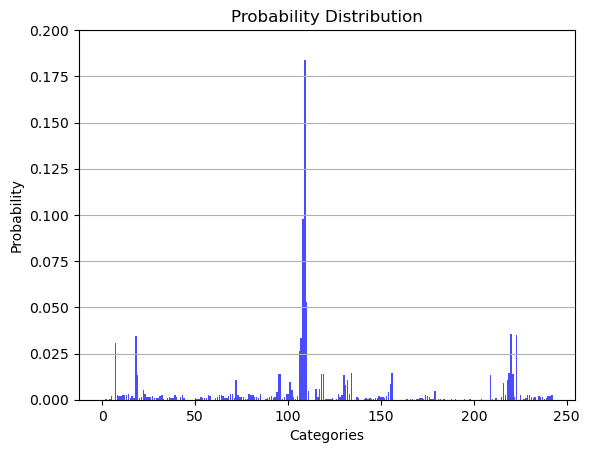

In [13]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.1, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [14]:
bulkloading_n = int(0.52 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 16, sample_n: 7193, bound_n: 3
Exceeding the number of keys in bin 17, sample_n: 8409, bound_n: 134
Exceeding the number of keys in bin 18, sample_n: 12873, bound_n: 12504
Exceeding the number of keys in bin 21, sample_n: 7182, bound_n: 2
Exceeding the number of keys in bin 22, sample_n: 37730, bound_n: 23382
Exceeding the number of keys in bin 25, sample_n: 7378, bound_n: 21
Exceeding the number of keys in bin 36, sample_n: 117838, bound_n: 46636
Exceeding the number of keys in bin 39, sample_n: 100467, bound_n: 54748
Exceeding the number of keys in bin 40, sample_n: 168378, bound_n: 104536
Exceeding the number of keys in bin 43, sample_n: 124220, bound_n: 66971
Exceeding the number of keys in bin 44, sample_n: 165527, bound_n: 129021
Exceeding the number of keys in bin 45, sample_n: 152958, bound_n: 102277
Exceeding the number of keys in bin 49, sample_n: 109795, bound_n: 79626
Exceeding the number of keys in bin 50, sample_n: 232423, bound_n: 2163

In [15]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
# KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

Total number of bins: 243


In [16]:
# inserted_keys = np.setdiff1d(data, bulkloading_keys)
# print("Insert number of records:", len(inserted_keys))
# print("Insert ratio:", len(inserted_keys) / len(data))

In [17]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

In [ ]:
# draw the estimated distribution and store the figure

# labels = x
# max_value = max(y)
# rounded_max_value = np.ceil(max_value * 50) / 50
# # rounded 0.05
# y_ = [ i * 100 for i in y]
# plt.rcParams['xtick.labelsize']=15
# plt.rcParams['ytick.labelsize']=15
# fig, ax = plt.subplots(figsize=(4, 2.5))
# ax.bar(labels, y_, color='blue', alpha=0.7)
# ax.set_xlabel('#Bin', fontsize = 15, fontname='Times New Roman')
# ax.set_ylabel('Prob (%)', fontsize = 15, fontname='Times New Roman')
# ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
# ax.set_xlim(-10, 310)
# ax.grid(axis='y')
# fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution_drift_01.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# # Show the plot
# fig.show()

In [ ]:
filepath = "/users/lingze/neurbench/data/draw/osm_cellid_drift_01.npz"
x = np.array(x)
y = np.array(y)
np.savez(filepath, x=x, y=y)

---
### Drift 0.3

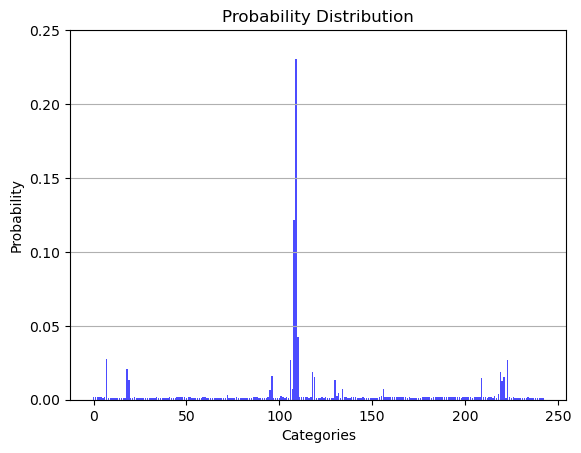

In [20]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.3, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [21]:
bulkloading_n = int(0.52 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 16, sample_n: 217731, bound_n: 3
Exceeding the number of keys in bin 17, sample_n: 217546, bound_n: 134
Exceeding the number of keys in bin 18, sample_n: 195550, bound_n: 12504
Exceeding the number of keys in bin 21, sample_n: 217733, bound_n: 2
Exceeding the number of keys in bin 22, sample_n: 168173, bound_n: 23382
Exceeding the number of keys in bin 25, sample_n: 217706, bound_n: 21
Exceeding the number of keys in bin 34, sample_n: 101179, bound_n: 90815
Exceeding the number of keys in bin 36, sample_n: 103954, bound_n: 46636
Exceeding the number of keys in bin 39, sample_n: 103235, bound_n: 54748
Exceeding the number of keys in bin 43, sample_n: 102339, bound_n: 66971
Exceeding the number of keys in bin 49, sample_n: 101633, bound_n: 79626
Exceeding the number of keys in bin 52, sample_n: 101310, bound_n: 87181
Exceeding the number of keys in bin 53, sample_n: 209993, bound_n: 4988
Exceeding the number of keys in bin 55, sample_n: 102357, bound_n

In [22]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
# KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

Total number of bins: 243


In [23]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

In [ ]:
# # draw the estimated distribution and store the figure

# labels = x
# max_value = max(y)
# rounded_max_value = np.ceil(max_value * 50) / 50
# # rounded 0.05
# y_ = [ i * 100 for i in y]
# plt.rcParams['xtick.labelsize']=15
# plt.rcParams['ytick.labelsize']=15
# fig, ax = plt.subplots(figsize=(4, 2.5))
# ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
# ax.set_xlabel('#Bin', fontsize = 15, fontname='Times New Roman')
# ax.set_ylabel('Prob (%)', fontsize = 15, fontname='Times New Roman')
# ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
# ax.set_xlim(-10, 310)
# ax.grid(axis='y')
# fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution_drift_03.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# # Show the plot
# fig.show()

In [ ]:
filepath = "/users/lingze/neurbench/data/draw/osm_cellid_drift_03.npz"
x = np.array(x)
y = np.array(y)
np.savez(filepath, x=x, y=y)

---
### Drift 0.5

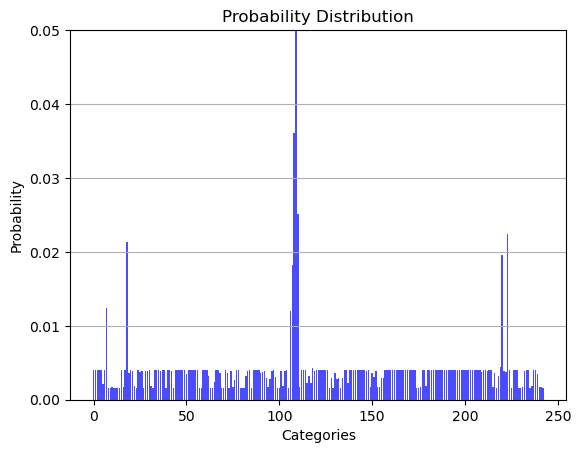

In [26]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.5, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [27]:
bulkloading_n = int(0.6 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 16, sample_n: 476071, bound_n: 3
Exceeding the number of keys in bin 17, sample_n: 476070, bound_n: 134
Exceeding the number of keys in bin 18, sample_n: 475981, bound_n: 12504
Exceeding the number of keys in bin 21, sample_n: 476071, bound_n: 2
Exceeding the number of keys in bin 22, sample_n: 475918, bound_n: 23382
Exceeding the number of keys in bin 24, sample_n: 244572, bound_n: 212516
Exceeding the number of keys in bin 25, sample_n: 476071, bound_n: 21
Exceeding the number of keys in bin 34, sample_n: 469032, bound_n: 90815
Exceeding the number of keys in bin 36, sample_n: 475376, bound_n: 46636
Exceeding the number of keys in bin 39, sample_n: 474901, bound_n: 54748
Exceeding the number of keys in bin 40, sample_n: 464239, bound_n: 104536
Exceeding the number of keys in bin 43, sample_n: 473724, bound_n: 66971
Exceeding the number of keys in bin 44, sample_n: 449894, bound_n: 129021
Exceeding the number of keys in bin 45, sample_n: 465161, bou

In [28]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
# KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

Total number of bins: 243


In [29]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

In [ ]:
# # draw the estimated distribution and store the figure

# labels = x
# max_value = max(y)
# rounded_max_value = np.ceil(max_value * 50) / 50
# # rounded 0.05
# y_ = [ i * 100 for i in y]
# plt.rcParams['xtick.labelsize']=15
# plt.rcParams['ytick.labelsize']=15
# fig, ax = plt.subplots(figsize=(4, 2.5))
# ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
# ax.set_xlabel('#Bin', fontsize = 15, fontname='Times New Roman')
# ax.set_ylabel('Prob (%)', fontsize = 15, fontname='Times New Roman')
# ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
# ax.set_xlim(-10, 310)
# ax.grid(axis='y')
# fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution_drift_05.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# # Show the plot
# fig.show()

In [ ]:
filepath = "/users/lingze/neurbench/data/draw/osm_cellid_drift_05.npz"
x = np.array(x)
y = np.array(y)
np.savez(filepath, x=x, y=y)

---
### Drift 0.7

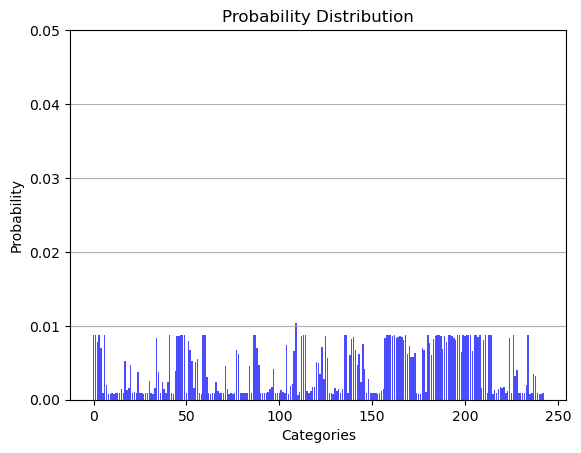

In [32]:
# Drift setting alpha = 0.1, unform drift
init_prob = find_q(prob, 0.7, skewed=False)
KeySetBinEncoder.plot_probability_distribution(init_prob)

In [33]:
bulkloading_n = int(1 * len(keys))
bulkloading_keys = sample_bulkloading_keyset(
    bin_idxs,
    init_prob,
    bin_idx_to_keys,
    bulkloading_n,
    verbose=True
)
print(len(bulkloading_keys)) 
print("Bulkloading key set size:", len(bulkloading_keys) / len(keys))

Exceeding the number of keys in bin 16, sample_n: 1730448, bound_n: 3
Exceeding the number of keys in bin 17, sample_n: 1728530, bound_n: 134
Exceeding the number of keys in bin 18, sample_n: 1547648, bound_n: 12504
Exceeding the number of keys in bin 21, sample_n: 1730462, bound_n: 2
Exceeding the number of keys in bin 22, sample_n: 1388550, bound_n: 23382
Exceeding the number of keys in bin 25, sample_n: 1730184, bound_n: 21
Exceeding the number of keys in bin 34, sample_n: 277477, bound_n: 90815
Exceeding the number of keys in bin 36, sample_n: 1044622, bound_n: 46636
Exceeding the number of keys in bin 39, sample_n: 921493, bound_n: 54748
Exceeding the number of keys in bin 40, sample_n: 179921, bound_n: 104536
Exceeding the number of keys in bin 43, sample_n: 728554, bound_n: 66971
Exceeding the number of keys in bin 44, sample_n: 175995, bound_n: 129021
Exceeding the number of keys in bin 45, sample_n: 180317, bound_n: 102277
Exceeding the number of keys in bin 47, sample_n: 1786

In [34]:
"""Bin the key set, get the distribution of key set
heuristically choose the bin size.
"""
bin_width_offset = 55
bin_idxs, ini_prob, _ = KeySetBinEncoder.bin_keyset_to_distribution(
    np.array(bulkloading_keys),
    bin_width_offset=bin_width_offset,
    verbose=True
)
# KeySetBinEncoder.plot_probability_distribution(ini_prob, bin_idxs.tolist())

Total number of bins: 243


In [35]:

# draw the picture of the bulkloading key 
prob_dict = {}
for i, idx in enumerate(bin_idxs):
    prob_dict[idx] = ini_prob[i]
y = [ prob_dict[i] if i in prob_dict else 0.0 for i in range(min_bin_num, max_bin_num+1) ]

In [ ]:
# # draw the estimated distribution and store the figure

# labels = x
# max_value = max(y)
# rounded_max_value = np.ceil(max_value * 50) / 50
# # rounded 0.05
# y_ = [ i * 100 for i in y]
# ax.set_xlabel('#Bin', fontsize = 15, fontname='Times New Roman')
# ax.set_ylabel('Prob (%)', fontsize = 15, fontname='Times New Roman')
# fig, ax = plt.subplots(figsize=(4, 2.5))
# ax.bar(labels, y_, color='#1F77B4', alpha=0.7)
# ax.set_xlabel('#Bin', fontsize = 15)
# ax.set_ylabel('Prob (%)', fontsize = 15)
# ax.set_ylim(0, 2)  # Set y-axis limits from 0 to 1
# ax.set_xlim(-10, 310)
# ax.grid(axis='y')
# fig.tight_layout()
# filepath = "/users/lingze/neurbench/data/keys/osm_cellids_200M_uint64_distribution_drift_07.pdf"
# fig.savefig(filepath, dpi = 800, bbox_inches = 'tight', pad_inches=0)
# # Show the plot
# fig.show()

In [ ]:
filepath = "/users/lingze/neurbench/data/draw/osm_cellid_drift_07.npz"
x = np.array(x)
y = np.array(y)
np.savez(filepath, x=x, y=y)